# Linear classification

Learning contents:
* Least squares for classification
* Perceptron
* Logistic regression
* Extra: multi-class logistic regression

In [1]:
# Dependencies
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() # this import just makes the plots prettier
import numpy as np

## Data
We'll be working with a dataset of handwritten digits. 
Let visualise some examples.

In [2]:
# We're using a subset of two classes for now
digits = load_digits(n_class=2)

In [3]:
# Handy plotting functions
x_min, x_max = -40, 40
y_min, y_max = -40, 40

def plot_examples():
    show_num = 4
    _, axes = plt.subplots(1, show_num)
    images_and_labels = list(zip(digits.images, digits.target))
    for ax, (image, label) in zip(axes[:], images_and_labels[:show_num]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % label)

def plot_scatter(data, target, n_class=2):
    plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar();
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

def plot_decision_boundary(data, weights):
    axes = plt.gca()
    x = np.array(axes.get_xlim())
    y = - x * weights[1]/weights[2] - weights[0]
    plt.plot(x, y, color='black', linewidth=0.7)

def plot_mesh(X, pred_fn, n_class=2):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    plt.axis('tight')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

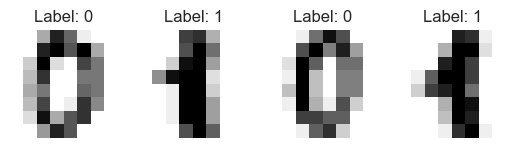

In [4]:
plot_examples()

In [5]:
# The dataset contains 2D data in the form of the `images` attribute, 
# as well as a 1D-version called `data`, where the images have been flattened. 
np.array_equal(digits.images[0].flatten(), digits.data[0])

True

In [6]:
# We can get a 2D version of the data using PCA
pca = PCA(n_components=2)
X = pca.fit_transform(digits.data) # this is the representation, we'll be working with

In [7]:
# Out targets are in the set {0,1}
t_01 = digits.target

C:\Users\matti\AppData\Local\Temp\ipykernel_2488\1157554636.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


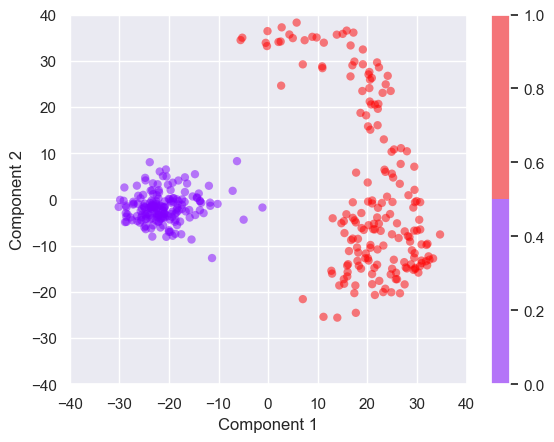

In [8]:
# Let's plot all the data in 2D
plot_scatter(X, t_01)

## 1) Least Squares

### 1.1) Find the weight vector using Least Squares for classification
Find the optimal weights **W** of size (M+1,1), where M is the size of each data point **X_n**={x_1n,...,x_Mn} , in this problem each **X_n** has size 2 because it has 2 coordinates. And where N is the number of data points. To find the optimal weight calculation look at slides 13 and 15 of Lecture 13. Hint: Remember to augment the data with a column of 1's so that the initial weight, **w_0**, can  be multiplied by 1. This means: construct the matrix **X_least_squares** =[1,**x**], where **X** is the matrix of data points, in this case **X** will have dimensions [N x M] (N data points for every vector of M components, in this case with M=2 components/coordinates) and **X_least_squares** will have dimensions [N x M+1] (n datapoints with 2 coordinates and the extra row of 1's to multiply **w_0** by). Note that **X** ranges 1,...,N and each row in **X** ranges from 1 to M.

In [9]:
X_tilde =  np.hstack((np.ones((X.shape[0], 1)), X))

In [10]:
def linear_regression(X,t_01):
    T = np.array([[0, 1] if target == 1 else [1, 0] for target in t_01])
    return np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ T

W_lr = linear_regression(X_tilde,t_01)
W_lr

array([[ 0.49444444,  0.50555556],
       [-0.02182423,  0.02182423],
       [-0.00478603,  0.00478603]])

### 1.2) Create class predictions using the weight vector
Create a function called 'predict' that takes as arguments: the weights vector, **W**, found using the Least Squares method for classification in the previous step, the augmented data created by adding a row of 1's to the data, **X**, and a decision boundary, which will be scalar that will be used to determine the boundary of classification. The function should return the predictions for each data point, so it should return an array of [Nx1] values, based on the decision boundary value for classification. See slide 13, Lecture 13. Finally, check that the predictions are the same than the original target vector.

In [11]:
def predict(W_tilde, X_tilde):
    ys = [W_tilde.T @ x_tilde[:, np.newaxis] for x_tilde in X_tilde]
    pred = [np.argmax(y) for y in ys]
    return pred
    
t_least_squares = predict(W_lr, X_tilde)
np.array_equal(t_01,t_least_squares)

True

### 1.3) Plot the decision boundary 
You can do this either by plotting a line on the boundary or creating a mesh of all predictions. Substitute in the code below **W_least_squares** and **X_least_squares** by the names you have defined them in the previous steps, in order to show the plot.

In [3]:
plot_scatter(X, t_least_squares)
plot_decision_boundary(X, W_lr)

NameError: name 'plot_scatter' is not defined

## 2) Perceptron

Implement the perceptron algorithm for classification (see slide 20 of Lecture 13) for 1000 epochs. For this, consider **PHI(X)** as a polynomial basis of order D=2, this means **PHI(X)_n** = { 1, X, X^2 }, so **PHI(X)** will have dimensions [Nx(MxD+1)]. In this case D=2 (polynomial of order 2), M=2 (each data point **X_n** has two coordinates) and N is 360 data points.  Assume that the data is already suffled. To initialize the weight vector **w_0**, we set the random seed to 13 and make that the weight vector is in the range of {-1,1}. In addition, a learning_rate of 0.1 should do the job.
Hint: remember to change the target representation range so that each data point will have a class of -1 or 1.

In [13]:
np.random.seed(42)
def perceptron(X_tilde, t_01, epochs=1000, eta=0.1):
    t_01 = np.array([-1 if t==0 else 1 for t in t_01])
    eta = 0.1
    w_0 = np.random.rand(len(X_tilde[0]))
    
    for epoch in range(epochs):
        shuffle_indices = np.random.permutation(len(X_tilde))
        X_tilde = X_tilde[shuffle_indices]
        t_01 = t_01[shuffle_indices]
        
        for x, t in zip(X_tilde, t_01):
            if np.dot(w_0, x) * t < 0:
                E_p = -x * t
                w_0 -= eta * E_p
    
    return w_0

W_perceptron = perceptron(X_tilde,t_01)
W_perceptron

array([1.07454012, 6.39362748, 1.10224533])

### 2.2) Perform class-predictions
Again, you should be able to classify all correctly by checking that the predictions are the same as the provided target vector. Notice both predictions and target vector are an array of N components of 0's and 1's, so you have to make your predictions go back to 1's and 0's instead of -1's and 1's.

In [14]:
def perceptron_classify(weights, X_tilde):
    return np.array([1 if weights @ x.T > 0 else 0 for x in X_tilde])

t_perceptron = perceptron_classify(W_perceptron, X_tilde)
np.array_equal(t_01,t_perceptron)

True

### 2.3) Plot the decision boundary
To plot the decision boundary, adapt the names from your weights and PHI matrix in the code below.

C:\Users\matti\AppData\Local\Temp\ipykernel_2488\1157554636.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


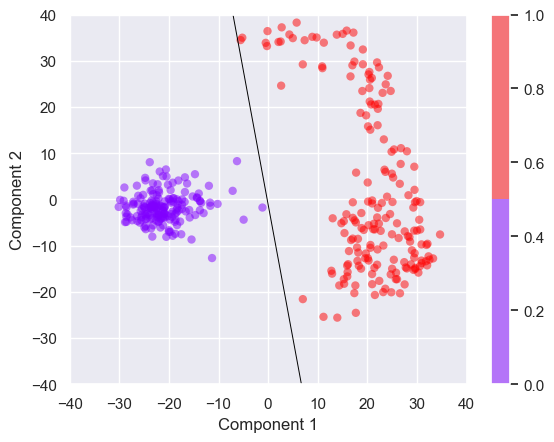

In [15]:
plot_scatter(X, t_perceptron)
plot_decision_boundary(X, W_perceptron)

## 3) Logistic Regression
### 3.1) Find the weight vector using the Logistic Regression
To find the weight vector compute the gradient of error function with respect to **w** , Delta(E(**w**)) (see slide 20 of Lecture 14). **PHI(X)** has dimensions [Nx(M+1)], so it only has an added row of 1's, in this case it has dimension 360x3. And then, considering that **w_0** is provided by initializing it randomly, do, for 30 epochs a weight update: w (tau +1) = w (tau ) − (learning rate) * deltaE (w (tau ))

In [16]:
# initialise W_0 randomly
np.random.seed(42)
W_0 = 2 * np.random.random((1, 3)) -1 # random values in the range [-1,1]

# Our target vectors should be {0, 1}
t_01 = digits.target

In [17]:
def sigmoid(a):
    if a >= 0:
        return 1 / ( 1 + np.exp(-a) )
    else:
        return np.exp(a) / ( 1 + np.exp(a))

def logistic_weights(W_0, X_tilde, t_01, epochs=30, eta=0.1):
    W_0 = W_0.ravel()
    for _ in range(epochs):
        y = np.array([sigmoid(W_0 @ x) for x in X_tilde])
        E = X_tilde.T @ (y - t_01)
        W_0 -= eta * E

    return W_0

W_logistic = logistic_weights(W_0, X_tilde, t_01)
W_logistic

array([  9.66097248, 163.02086566,  52.90993539])

### 3.2) Perform class-predictions

In [18]:
def logistic_prediction(weights, data):
    return [1 if sigmoid(weights @ x.T)>0.5 else 0 for x in data]

t_logistic = logistic_prediction(W_logistic, X_tilde)

### 3.3) Plot the decision boundary
Replace W_logistic and X_logistic with the name of your data.

C:\Users\matti\AppData\Local\Temp\ipykernel_2488\1157554636.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


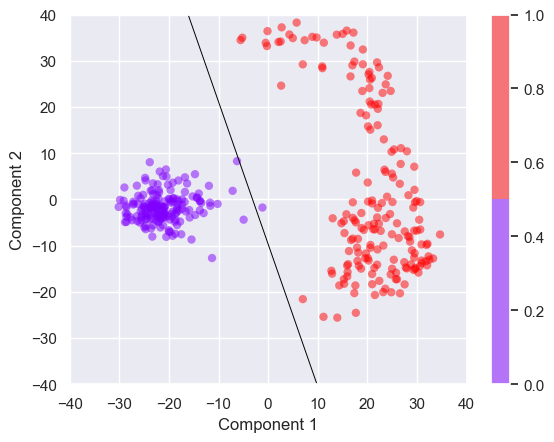

In [19]:
plot_scatter(X, t_logistic)
plot_decision_boundary(X, W_logistic)

## 4) Multi-class logistic regression
Repeat 3) but now for multiple classes, i.e. compute the weight matrix, perform predictions (you shold be able to get about 93% accuracy) and plot decision boundaries.

Hint: You will need to use a one-hot encoding of the targets

In [39]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
pca = PCA(n_components=2)
X_mult = pca.fit_transform(digits.data)

learning_rate = 0.1

# We need to do a one_hot encoding of our data:
# I.e. 0 -> [1,0,0], 1 -> [0,1,0], 2 -> [0,0,1]
def one_hot(targets, n_class=n_class):
    res = np.eye(n_class)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[n_class])

t_oh = one_hot(digits.target, n_class)



C:\Users\matti\AppData\Local\Temp\ipykernel_2488\1157554636.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


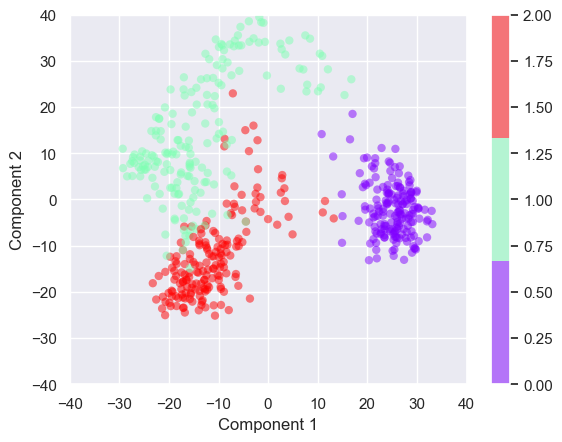

In [24]:
plot_scatter(X_mult, digits.target, n_class=n_class)

C:\Users\matti\AppData\Local\Temp\ipykernel_2488\1157554636.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


accuracy: 91.24767225325886


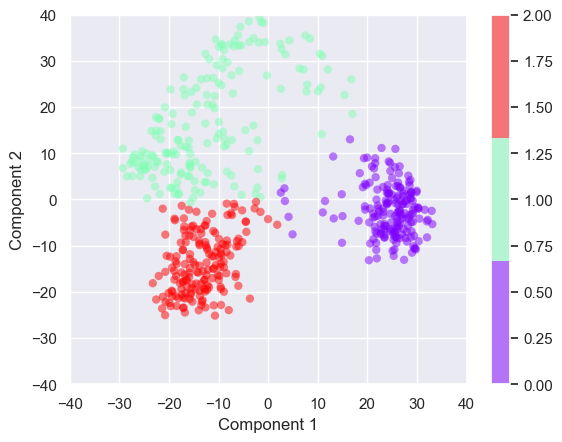

In [63]:
np.random.seed(42)

def sigmoid(a):
    exp_a = np.exp(a - np.max(a, axis=1, keepdims=True))
    return exp_a / np.sum(exp_a, axis=1, keepdims=True)

def weights_logistic(W, X_tilde, t_oh, epochs=30, eta=0.1):
    for _ in range(epochs):
        y = sigmoid(X_tilde @ W.T)
        E = X_tilde.T @ (y - t_oh)
        W -= eta * E.T
    return W

def prediction(weights, data):
    z = data @ weights.T
    y = sigmoid(z)
    return np.argmax(y, axis=1)

W = 2 * np.random.random((n_class, X_mult.shape[1]+1)) - 1
X_tilde_mult = np.c_[np.ones(X_mult.shape[0]), X_mult]

W = weights_logistic(W, X_tilde_mult, t_oh)
t_pred = prediction(W, X_tilde_mult)

plot_scatter(X_mult, t_pred, n_class = n_class)
print(f"accuracy: {(t_pred == digits.target).mean() * 100}")

## 5) (Optional) Multi-class logistic regression on original data representation
Repeat exercise 4), but use the original data representation instead.
You can omit the plots.

Hint: To get 100% accuracy, you can try to:
- Rescale your data to the range [0,1]
- Run 1000 epochs with learning_rate = 0.1